# 读入相位图，归一化，在变成0-pi，在通过物理模型prop（得到强度图（没有进行归一化）

In [1]:
import sys

from library import *

/mnt/data/optimal/tangyuhang/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #分布式训练时用默认
print(f"PyTorch is running on GPU: {torch.cuda.current_device()}")

PyTorch is running on GPU: 0


In [3]:
a = 128*15
c = 128*20
shape = [a,c]


name = 'diff_pi' # fashion_tshirt_256，smile_face_256,imagenet256 #相位图名字0801

# 相位图和txt文件路径


phrase_path =f'/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/phynet_git/traindata/gt/{shape[0]}_{shape[1]}_{name}.png'


phrase_path_txt = f'/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/phynet_git/traindata/gt/{shape[0]}_{shape[1]}_{name}_prop_pi.txt'
phrase_pathpng = f'/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/phynet_git/traindata/gt/{shape[0]}_{shape[1]}_{name}_prop_pi.png'
# 强度图和txt文件路径
measured_y_path = f'/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/phynet_git/traindata/exp/{shape[0]}_{shape[1]}_{name}_prop_pi.png' #生成的训练图片和txt存储路径
measured_y_path_txt = f'/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/phynet_git/traindata/exp/{shape[0]}_{shape[1]}_{name}_prop_pi.txt'

In [4]:
# 读入相位图,并将其归一化


raw_img = my_readimage(phrase_path)
img_phrase = raw_img[:,0:shape[0],0:shape[1]]
img_phrase = img_phrase.to(device)
img_phrase = img_phrase*torch.pi

print(f'shape of phrase_image:{img_phrase.shape}')
print(f'type of phrase_image:{img_phrase.dtype}')
print(f'max of phrase_image:{img_phrase.max()}')

np.savetxt(phrase_path_txt,img_phrase.cpu().reshape(shape[0],shape[1]),fmt='%.10e',delimiter=",") #frame: 相位图 array:存入文件的数组

shape of phrase_image:torch.Size([1, 480, 640])
type of phrase_image:torch.float32
max of phrase_image:3.1415927410125732


RuntimeError: shape '[1920, 2560]' is invalid for input of size 307200

max of img_phrase:3.129272699356079


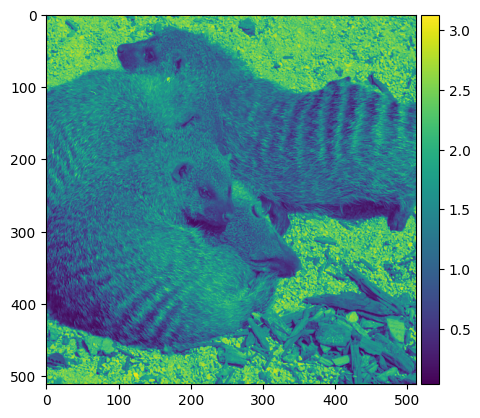

In [25]:

print(f'max of img_phrase:{img_phrase.max()}')
from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = plt.subplot()


im = ax.imshow(img_phrase.cpu().reshape(shape[0],shape[1]))

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.savefig(phrase_pathpng)
plt.show()

In [26]:
'''
1.注意传播距离，确保生成图像的传播距离与训练的传播距离一致，一般默认一致
2.输入数据的维度应该为二维，如果是三维，就算值一样傅里叶变换后也不一样
'''

measured_y = prop(img_phrase[0,0 :shape[0], 0:shape[1]])

print(f'shape of measured_y:{measured_y.shape}')
print(f'type of measured_y:{measured_y.dtype}')
print(f'max of measured_y:{measured_y.max()}')
np.savetxt(measured_y_path_txt,measured_y.cpu().reshape(shape[0],shape[1]),fmt='%.10e',delimiter=",") #frame: measured_y array:存入文件的数组

d:\tyh\PhysenNet_git\library.py:267: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  qx = torch.range(1-Nx/2, Nx/2, 1).cuda()
d:\tyh\PhysenNet_git\library.py:268: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  qy = torch.range(1-Ny/2, Ny/2, 1).cuda()
c:\Users\sunjiawei\anaconda3\envs\tyh1\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


shape of measured_y:torch.Size([512, 512])
type of measured_y:torch.float32
max of measured_y:5.285124778747559


max of measured_y:5.28515625


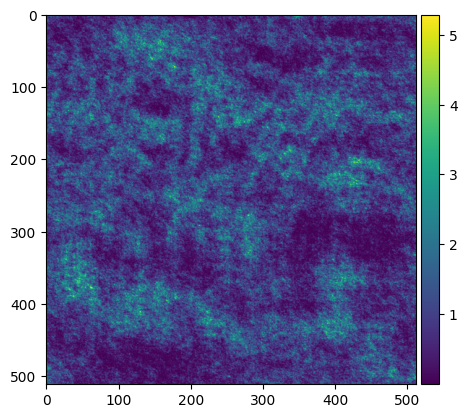

In [27]:
matrix = np.loadtxt(measured_y_path_txt,dtype=np.float16,delimiter=",") # frame:文件
print(f'max of measured_y:{matrix.max()}')
from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = plt.subplot()


im = ax.imshow(matrix)

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.savefig(measured_y_path)
plt.show()

# 验证角谱法公式是否正确

In [ ]:
def prop(img,  dx, dy, lam, dist):

    print(torch.max(img))

    img_phase = img #*torch.pi

    print(torch.max(img_phase))
    
    H = torch.exp(1j * img_phase) 
    fft_H = torch.fft.ifftshift(torch.fft.fft2(H)).to(device)
    # H = torch.exp(1j * img) 
    # (Ny,Nx) = H.size()
    # fft_H = torch.fft.ifftshift(torch.fft.fft2(H)).to(device)
    # the axis in frequency space
    # qx = torch.linspace(0.25/xstart, 0.25/xend, nx) * nx
    # qy = torch.linspace(0.25/ystart, 0.25/yend, ny) * ny
    
    # qx = torch.range(1-Nx/2, Nx/2, 1).to(device)
    # qy = torch.range(1-Ny/2, Ny/2, 1).to(device)
    # # print(qx)
    # y, x = torch.meshgrid(qx, qy)
    # # print(f'mesh_qx{mesh_qx}')
    # # print(f'mesh_qy{mesh_qy}')
    (Ny,Nx) = H.shape[0],H.shape[1]
    
    qx = torch.range(1-Nx/2, Nx/2, 1).to(device)
    qy = torch.range(1-Ny/2, Ny/2, 1).to(device)
    y, x = torch.meshgrid(qy, qx)
    r=(2*torch.pi*x/(dx*Nx))**2+(2*torch.pi*y/(dy*Ny))**2

    k=2*torch.pi/lam

    kernel=torch.exp(-1*1j*torch.sqrt(k**2-r)*dist)

    fft_HH=fft_H[:,:]*kernel
    fft_HH=torch.fft.fftshift(fft_HH)

    Ud=torch.fft.ifft2(fft_HH)

    Id=Ud
    Id1=torch.angle(Ud)
    intensity = torch.abs(Id) * torch.abs(Id)
 
    # print(f'torch.max(intensity){torch.max(intensity)}')
    # print(f'intensity{intensity}')

    return intensity

In [ ]:
import sys
sys.path.append('/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/My_PhySenNet_torch')
from library import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #分布式训练时用默认
print(f"PyTorch is running on GPU: {torch.cuda.current_device()}")

In [ ]:
# 相位图和txt文件路径
phrase_path_txt_gt =f'/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/My_PhySenNet_torch/utils/smile_face_1080.png'


# 强度图和txt文件路径
measured_y_path_txt_gt = f'./1080gt.png' #2.归一化到任意值后相位经过物理模型后强度图片存放路径


In [ ]:
matrix_gt = cv2.imread(phrase_path_txt_gt)
matrix_gt = cv2.cvtColor(matrix_gt, cv2.COLOR_BGR2GRAY) #三通道转换为单通道
matrix_gt = torch.tensor(matrix_gt.reshape(matrix_gt.shape[0],matrix_gt.shape[1]))

matrix_gt = torch.tensor(matrix_gt)
matrix_gt = matrix_gt/torch.max(matrix_gt)*torch.pi*2
print(f'shape of matrix_gt:{matrix_gt.shape}')
print(f'type of matrix_gt:{matrix_gt.dtype}')
print(f'max of matrix_gt:{matrix_gt.max()}')

dx = 2.2e-6
dy = dx
lam = 532e-9
d = 0.01

measured_y_gt = prop(matrix_gt,dx,dy,lam,d)


print(f'shape of measured_y:{measured_y_gt.shape}')
print(f'type of measured_y:{measured_y_gt.dtype}')
print(f'max of measured_y:{measured_y_gt.max()}')


my_saveimage(measured_y_gt.cpu().detach().numpy(),measured_y_path_txt_gt)



# 读入相位，经过角谱法物理模型得到强度图

In [1]:
import sys
from library import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #分布式训练时用默认
print(f"PyTorch is running on GPU: {torch.cuda.current_device()}")

/mnt/data/optimal/tangyuhang/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch is running on GPU: 0


In [7]:
a = 128*12
c = 128*12
shape = [a,c]

name = 'ref_pi' # fashion_tshirt_256，smile_face_256,imagenet256 #相位图名字0801

# 相位图和txt文件路径
phrase_path =f'/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/phynet_git/traindata/gt/{name}.txt'
# phrase_path =f'/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/phynet_git/traindata/gt/{shape[0]}_{shape[1]}_{name}.txt'


phrase_path_txt = f'/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/phynet_git/traindata/gt/{shape[0]}_{shape[1]}_{name}_01_prop_pi.txt'
phrase_pathpng = f'/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/phynet_git/traindata/gt/{shape[0]}_{shape[1]}_{name}_01_prop_pi.png'
# 强度图和txt文件路径
measured_y_path = f'/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/phynet_git/traindata/exp/{shape[0]}_{shape[1]}_{name}_01_prop_pi.png' #生成的训练图片和txt存储路径
measured_y_path_txt = f'/mnt/data/optimal/tangyuhang/workspace/iopen/ai4optical/phynet_git/traindata/exp/{shape[0]}_{shape[1]}_{name}_01_prop_pi.txt'

shape of matrix_gt:torch.Size([1536, 1536])
max of matrix_gt:3.141592502593994


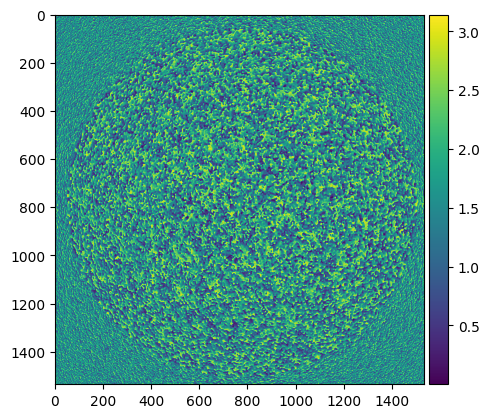

In [8]:
matrix_gtraw = np.loadtxt(phrase_path,dtype=np.float32,delimiter=",") # frame:文件
matrix_gtraw = torch.tensor(matrix_gtraw).to(device)

b = 470
d = 150
# b = 0
# d = 0
matrix_gt = matrix_gtraw[0+d :shape[0]+d, 0+b:shape[1]+b]

print(f'shape of matrix_gt:{matrix_gt.shape}')
print(f'max of matrix_gt:{matrix_gt.max()}')
my_saveimage(matrix_gt.cpu().detach().numpy(),phrase_pathpng)
np.savetxt(phrase_path_txt,matrix_gt.cpu().reshape(shape[0],shape[1]),fmt='%.10e',delimiter=",") #frame: 相位图 array:存入文件的数组




shape of measured_y:torch.Size([1536, 1536])
type of measured_y:torch.float32
max of measured_y:11.944185256958008


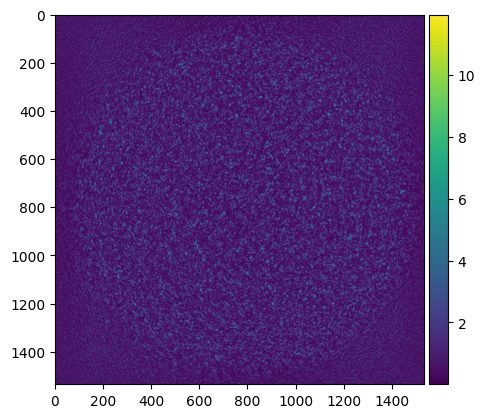

In [9]:

measured_y_gt = prop(matrix_gt,dist=0.01)


print(f'shape of measured_y:{measured_y_gt.shape}')
print(f'type of measured_y:{measured_y_gt.dtype}')
print(f'max of measured_y:{measured_y_gt.max()}')
# if measured_y_gt.max()>15:
    
#     measured_y_gt[measured_y_gt>15]=15

my_saveimage(measured_y_gt.cpu().detach().numpy(),measured_y_path)
np.savetxt(measured_y_path_txt,measured_y_gt.cpu().reshape(shape[0],shape[1]),fmt='%.10e',delimiter=",") #frame: 相位图 array:存入文件的数组

# 读入真实数据的相位（-pi到pi），对于小于零的相位变成0，将相位变成0-pi，经过角谱法物理模型得到强度图

In [41]:
import sys
from library import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #分布式训练时用默认
print(f"PyTorch is running on GPU: {torch.cuda.current_device()}")

PyTorch is running on GPU: 0


In [42]:
a = 128*12
c = 128*12
shape = [a,c]

name = 'phase_facet_ref' # fashion_tshirt_256，smile_face_256,imagenet256 #相位图名字0801

# 相位图和txt文件路径
phrase_path =f'D:\\tyh\\PhysenNet_realdata\\traindata\\gt\\{name}.txt'


phrase_path_txt = f'D:\\tyh\\PhysenNet_realdata\\traindata\\gt\\pi{shape[0]}_{shape[1]}_{name}_prop_pi.txt'
phrase_pathpng = f'D:\\tyh\\PhysenNet_realdata\\traindata\gt\\pi{shape[0]}_{shape[1]}_{name}_prop_pi.png'
# 强度图和txt文件路径
measured_y_path = f'D:\\tyh\\PhysenNet_realdata\\traindata\\exp\\pi{shape[0]}_{shape[1]}_{name}_prop_pi.png' #生成的训练图片和txt存储路径
measured_y_path_txt = f'D:\\tyh\\PhysenNet_realdata\\traindata\\exp\\pi{shape[0]}_{shape[1]}_{name}_prop_pi.txt'

shape of matrix_gt:torch.Size([1536, 1536])
max of matrix_gt:3.141592025756836
min of matrix_gt:-3.1415910720825195
min of matrix_gt:9.999999974752427e-07


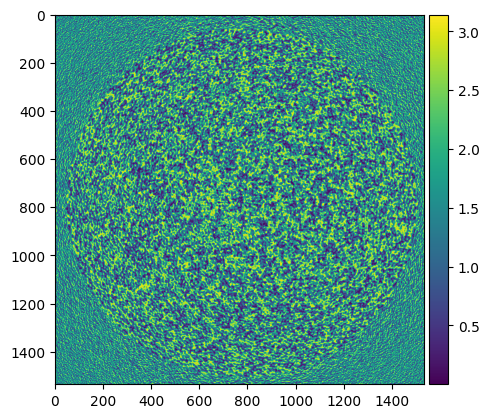

In [43]:
matrix_gtraw = np.loadtxt(phrase_path,dtype=np.float32,delimiter=",") # frame:文件
matrix_gtraw = torch.tensor(matrix_gtraw).to(device)

b = 470
d = 150
matrix_gt = matrix_gtraw[0+d :shape[0]+d, 0+b:shape[1]+b]

print(f'shape of matrix_gt:{matrix_gt.shape}')
print(f'max of matrix_gt:{matrix_gt.max()}')
print(f'min of matrix_gt:{matrix_gt.min()}')
# matrix_gt[matrix_gt<0]=0
matrix_gt=torch.abs(matrix_gt)
print(f'min of matrix_gt:{matrix_gt.min()}')
my_saveimage(matrix_gt.cpu().detach().numpy(),phrase_pathpng)
np.savetxt(phrase_path_txt,matrix_gt.cpu().reshape(shape[0],shape[1]),fmt='%.10e',delimiter=",") #frame: 相位图 array:存入文件的数组




d:\tyh\PhysenNet_realdata\library.py:267: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  qx = torch.range(1-Nx/2, Nx/2, 1).cuda()
d:\tyh\PhysenNet_realdata\library.py:268: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  qy = torch.range(1-Ny/2, Ny/2, 1).cuda()


shape of measured_y:torch.Size([1536, 1536])
type of measured_y:torch.float32
max of measured_y:12.263009071350098


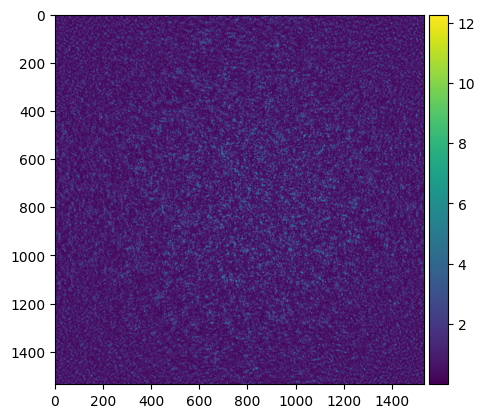

In [44]:

measured_y_gt = prop(matrix_gt)


print(f'shape of measured_y:{measured_y_gt.shape}')
print(f'type of measured_y:{measured_y_gt.dtype}')
print(f'max of measured_y:{measured_y_gt.max()}')
# if measured_y_gt.max()>15:
    
#     measured_y_gt[measured_y_gt>15]=15

my_saveimage(measured_y_gt.cpu().detach().numpy(),measured_y_path)
np.savetxt(measured_y_path_txt,measured_y_gt.cpu().reshape(shape[0],shape[1]),fmt='%.10e',delimiter=",") #frame: 相位图 array:存入文件的数组